<div style="background-color: #a83d36; color: #FFFFFF; padding: 10px; text-align: center; border-radius: 15px 15px 5px 5px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.5);">
  <h1 style="margin: 0; font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif; font-weight: bold; font-size: 32px;">Image Segmentation with U-Net</h1>
</div>

This project focuses on image segmentation using the U-Net architecture. U-Net, a convolutional neural network designed for biomedical image segmentation, excels in distinguishing detailed structures within images. By training on pairs of images and their corresponding segmentation masks, the model learns to predict accurate masks for new images. This technique is crucial in fields like medical imaging, autonomous driving, and satellite image analysis, where precise segmentation is essential. Through this project, we aim to implement and demonstrate the effectiveness of U-Net in segmenting images from a custom dataset.

<div style="text-align:center;">
<img src="images/carseg.png" style="width:500px;height:250;">
</div>



<div style="background-color: black; color: #FFFFFF; padding: 10px; text-align: center; border-radius: 15px 15px 5px 5px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.5);">
  <h1 style="margin: 0; font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif; font-weight: bold; font-size: 32px;">Data Preparation</h1>
</div>


In [1]:
# packages 

import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
import os
import imageio
import matplotlib.pyplot as plt
%matplotlib inline


2024-07-05 13:33:13.656130: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Load and Split the Data

path = '/Users/akshay/projects/unet'
image_path = os.path.join(path, './data/CameraRGB/')
mask_path = os.path.join(path, './data/CameraSeg/')

# List original image files in the image path directory
image_list_orig = os.listdir(image_path)

# Create full paths for images and masks
image_list = [image_path + i for i in image_list_orig]
mask_list = [mask_path + i for i in image_list_orig]
image_list

['/Users/akshay/projects/unet/./dat/CameraRGB/F7-31.png',
 '/Users/akshay/projects/unet/./dat/CameraRGB/03_00_190.png',
 '/Users/akshay/projects/unet/./dat/CameraRGB/F9-20.png',
 '/Users/akshay/projects/unet/./dat/CameraRGB/06_00_220.png',
 '/Users/akshay/projects/unet/./dat/CameraRGB/05_00_010.png',
 '/Users/akshay/projects/unet/./dat/CameraRGB/09_00_241.png',
 '/Users/akshay/projects/unet/./dat/CameraRGB/10_00_090.png',
 '/Users/akshay/projects/unet/./dat/CameraRGB/F3-41.png',
 '/Users/akshay/projects/unet/./dat/CameraRGB/F68-90.png',
 '/Users/akshay/projects/unet/./dat/CameraRGB/09_00_080.png',
 '/Users/akshay/projects/unet/./dat/CameraRGB/F4-60.png',
 '/Users/akshay/projects/unet/./dat/CameraRGB/03_01_181.png',
 '/Users/akshay/projects/unet/./dat/CameraRGB/F66-81.png',
 '/Users/akshay/projects/unet/./dat/CameraRGB/04_00_120.png',
 '/Users/akshay/projects/unet/./dat/CameraRGB/F8-60.png',
 '/Users/akshay/projects/unet/./dat/CameraRGB/02_02_210.png',
 '/Users/akshay/projects/unet/./da

Text(0.5, 1.0, 'Segmentation')

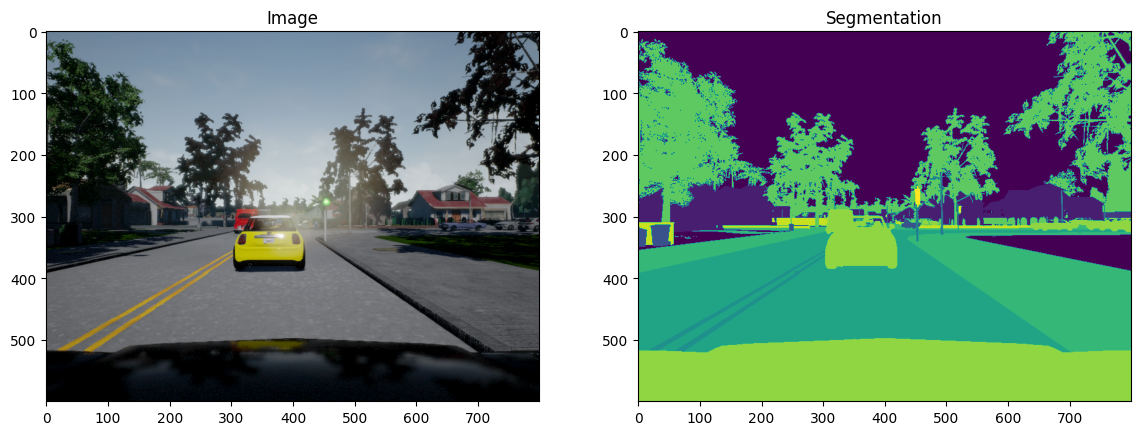

In [5]:
N = 15
img = imageio.v2.imread(image_list[N])  # Read the image at index N
mask = imageio.v2.imread(mask_list[N])  # Read the corresponding mask at index N

fig, arr = plt.subplots(1, 2, figsize=(14, 10))  # Create a subplot with 2 images side by side
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])  # Display only the first channel of the mask
arr[1].set_title('Segmentation')

In [6]:
# Create a TensorFlow dataset from the list of image file paths
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)

# Create a TensorFlow dataset from the list of mask file paths
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

# Iterate over the first 3 elements (file paths) of both datasets, pairing each image path with its corresponding mask path
for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    # Print each pair of (image_path, mask_path)
    print(path)


(<tf.Tensor: shape=(), dtype=string, numpy=b'/Users/akshay/projects/unet/./dat/CameraRGB/02_00_000.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/Users/akshay/projects/unet/./dat/CameraSeg/02_00_000.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/Users/akshay/projects/unet/./dat/CameraRGB/02_00_001.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/Users/akshay/projects/unet/./dat/CameraSeg/02_00_001.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'/Users/akshay/projects/unet/./dat/CameraRGB/02_00_010.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'/Users/akshay/projects/unet/./dat/CameraSeg/02_00_010.png'>)


In [7]:
image_filenames = tf.constant(image_list)  # Convert image list to TensorFlow constant
masks_filenames = tf.constant(mask_list)   # Convert mask list to TensorFlow constant

# Create a TensorFlow dataset from image and mask file names
dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

# Display the first image and mask file names in the dataset
for image, mask in dataset.take(1):
    print(image)
    print(mask)


tf.Tensor(b'/Users/akshay/projects/unet/./dat/CameraRGB/F7-31.png', shape=(), dtype=string)
tf.Tensor(b'/Users/akshay/projects/unet/./dat/CameraSeg/F7-31.png', shape=(), dtype=string)


In [8]:
# Preprocess Your Data

def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)  # Read the image file
    img = tf.image.decode_png(img, channels=3)  # Decode the PNG image
    img = tf.image.convert_image_dtype(img, tf.float32)  # Convert image to float32 dtype

    mask = tf.io.read_file(mask_path)  # Read the mask file
    mask = tf.image.decode_png(mask, channels=3)  # Decode the PNG mask
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)  # Reduce mask to single channel
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')  # Resize the image
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')  # Resize the mask

    return input_image, input_mask

# Apply the process_path function to each element in the dataset
image_ds = dataset.map(process_path)

# Apply the preprocess function to each element in the processed image dataset
processed_image_ds = image_ds.map(preprocess)

In [9]:
# Create Predicted Masks

def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

In [10]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

<div style="background-color: black; color: #FFFFFF; padding: 10px; text-align: center; border-radius: 15px 15px 5px 5px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.5);">
  <h1 style="margin: 0; font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif; font-weight: bold; font-size: 32px;">U-Net</h1>
</div>

U-Net, named for its U-shape, was originally created in 2015 for tumor detection, but in the years since has become a very popular choice for other semantic segmentation tasks.

<div style="text-align:center;">
<img src="images/unet.png" style="width:700px;height:400;">
</div>


--------------------------------------------------------------------------------------------------------------------------------------------
<br><br>

## Encoder (Downsampling Block)

**Contracting path** (Encoder containing downsampling steps):

Images are first fed through several convolutional layers which reduce height and width, while growing the number of channels.

The contracting path follows a regular CNN architecture, with convolutional layers, their activations, and pooling layers to downsample the image and extract its features. In detail, it consists of the repeated application of two 3 x 3 same padding convolutions, each followed by a rectified linear unit (ReLU) and a 2 x 2 max pooling operation with stride 2 for downsampling. At each downsampling step, the number of feature channels is doubled.


<img src="images/encoder.png" style="width:400;height:500;">



In [11]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """

    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(inputs)
    
    conv = Conv2D(n_filters, # Number of filters
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='he_normal')(conv)

    
    # if dropout_prob > 0 add a dropout layer, with the variable dropout_prob as parameter
    if dropout_prob > 0:

        conv = Dropout(dropout_prob)(conv)

         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:

        next_layer = MaxPooling2D(2,strides=2)(conv)

        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection


--------------------------------------------------------------------------------------------------------------------------------------------
<br><br>

## Decoder (Upsampling Block)
<div style="text-align:right;">
  <img src="images/decoder.png" style="width:400; height:500;">
</div>


**Expanding path** (Decoder containing upsampling steps):

The expanding path performs the opposite operation of the contracting path, growing the image back to its original size, while shrinking the channels gradually.

In detail, each step in the expanding path upsamples the feature map, followed by a 2 x 2 convolution (the transposed convolution). This transposed convolution halves the number of feature channels, while growing the height and width of the image.

Next is a concatenation with the correspondingly cropped feature map from the contracting path, and two 3 x 3 convolutions, each followed by a ReLU. You need to perform cropping to handle the loss of border pixels in every convolution.

In [12]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    

    up = Conv2DTranspose(
                 n_filters,    # number of filters
                 3,# Kernel size
                 strides=2,
                 padding='same')(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = concatenate([up, contractive_input], axis=3)
    
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(merge)
    
    conv = Conv2D(n_filters, # Number of filters
                  3,# Kernel size   
                  activation='relu',
                  padding='same',
                  kernel_initializer= 'he_normal')(conv)

    
    return conv




<br><br>

<div style="background-color: black; color: #FFFFFF; padding: 10px; text-align: center; border-radius: 15px 15px 5px 5px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.5);">
  <h1 style="margin: 0; font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif; font-weight: bold; font-size: 32px;">U-Net Model Architecture</h1>
</div>

**Final Feature Mapping Block**: In the final layer, a 1x1 convolution is used to map each 64-component feature vector to the desired number of classes. The channel dimensions from the previous layer correspond to the number of filters used, so when you use 1x1 convolutions, you can transform that dimension by choosing an appropriate number of 1x1 filters. When this idea is applied to the last layer, you can reduce the channel dimensions to have one layer per class. 

The U-Net network has 23 convolutional layers in total.

In [13]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    # Contracting Path (encoding)

    # conv_block with the inputs of the unet_ model and n_filters
    cblock1 = conv_block(inputs=inputs, n_filters=n_filters*1)

    cblock2 = conv_block(inputs=cblock1[0], n_filters=n_filters*2)
    
    cblock3 = conv_block(inputs=cblock2[0], n_filters=n_filters*4)
    
    # Include a dropout of 0.3 for this layer
    cblock4 = conv_block(inputs=cblock3[0], n_filters=n_filters*8,dropout_prob=0.3)
    
    # Include a dropout of 0.3 for this layer, and avoid the max_pooling layer
    cblock5 = conv_block(inputs=cblock4[0], n_filters=n_filters*16,dropout_prob=0.3, max_pooling=False) 

    
    # Expanding Path (decoding)

    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters*8)

    ublock7 = upsampling_block(ublock6, cblock3[1], n_filters*4)
    
    ublock8 = upsampling_block(ublock7, cblock2[1], n_filters*2)
    
    ublock9 = upsampling_block(ublock8, cblock1[1], n_filters*1)


    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    # Conv2D layer with n_classes filter, kernel size of 1 and a 'same' padding
    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)
    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)
    return model

In [14]:
# Set Model Dimensions
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [15]:
# model summary
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 128, 3)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 96, 128, 32)          896       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 96, 128, 32)          9248      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 48, 64, 32)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

In [16]:
# Loss Function

unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [17]:
EPOCHS = 40  # Number of epochs to train the model
VAL_SUBSPLITS = 5  # Number of validation splits 
BUFFER_SIZE = 500  # Buffer size for shuffling the dataset
BATCH_SIZE = 32  # Batch size for training

# Prepare the training dataset: cache it, shuffle it, and batch it
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)  # Print the structure of the dataset elements


# Train the model
model_history = unet.fit(train_dataset, epochs=EPOCHS)



(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/40
32/32 [==============================] - 126s 4s/step - loss: 2.6494 - accuracy: 0.3122
Epoch 2/40
32/32 [==============================] - 121s 4s/step - loss: 1.2224 - accuracy: 0.6169
Epoch 3/40
32/32 [==============================] - 103s 3s/step - loss: 0.7959 - accuracy: 0.7410
Epoch 4/40
32/32 [==============================] - 106s 3s/step - loss: 0.6101 - accuracy: 0.8047
Epoch 5/40
32/32 [==============================] - 105s 3s/step - loss: 0.4889 - accuracy: 0.8449
Epoch 6/40
32/32 [==============================] - 118s 4s/step - loss: 0.4667 - accuracy: 0.8528
Epoch 7/40
32/32 [==============================] - 132s 4s/step - loss: 0.3939 - accuracy: 0.8773
Epoch 8/40
32/32 [==============================] - 113s 4s/step - loss: 0.3574 - accuracy: 0.8875
Epoch 9/40
32/32 [==============================] - 122s 4s/step - loss: 0.3401 - accur

In [18]:
# Save the trained model
model_save_path = ''  # Specify your desired path
unet.save('DeepSegNet_V3.h5')

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(




<div style="background-color: black; color: #FFFFFF; padding: 10px; text-align: center; border-radius: 15px 15px 5px 5px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.5);">
  <h1 style="margin: 0; font-family: 'Helvetica Neue', Helvetica, Arial, sans-serif; font-weight: bold; font-size: 32px;">Model Predictions</h1>
</div>

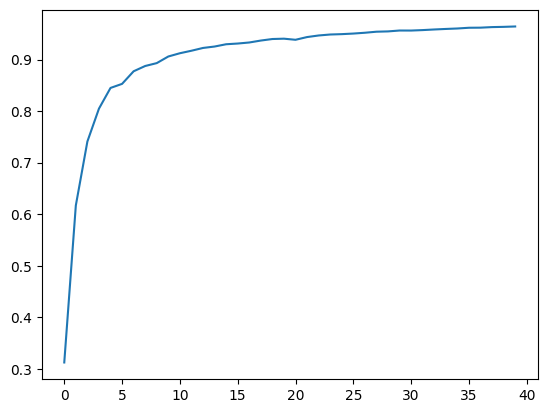

In [19]:
# Plot Model Accuracy
plt.plot(model_history.history["accuracy"])

In [20]:
# Show Predictions

def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 1s 1s/step


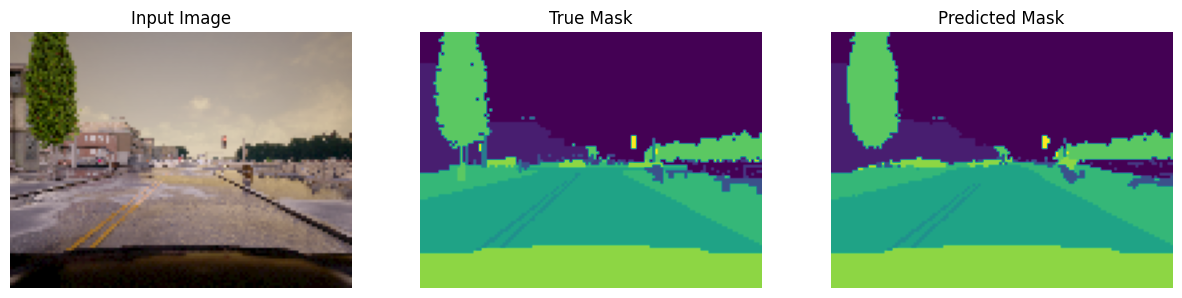

1/1 [==============================] - 1s 864ms/step


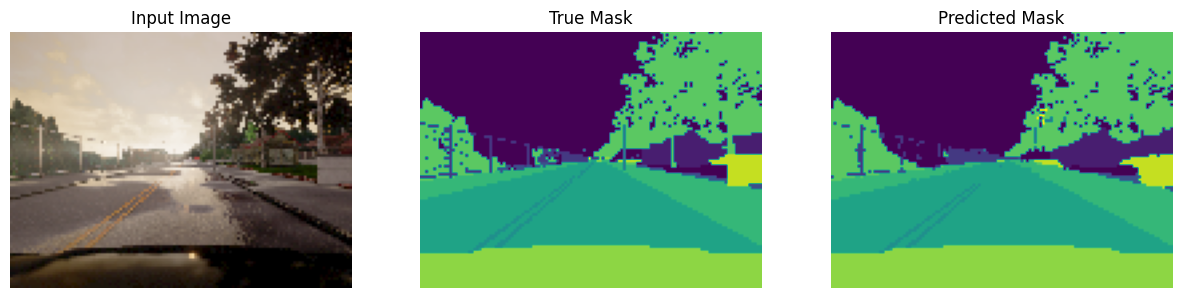

1/1 [==============================] - 1s 861ms/step


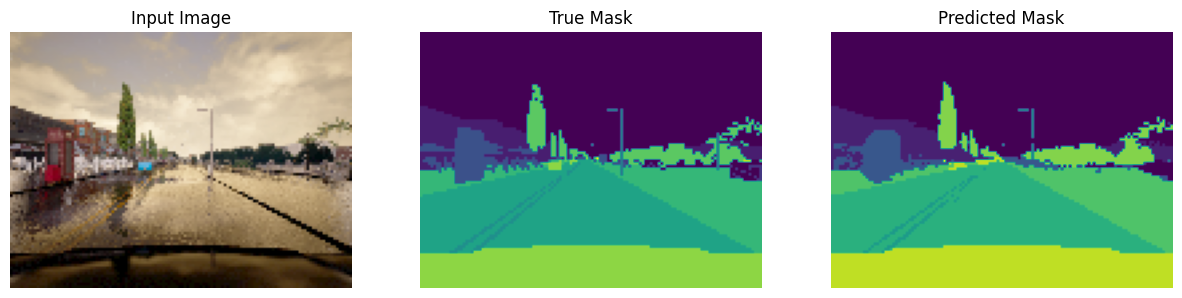

1/1 [==============================] - 1s 881ms/step


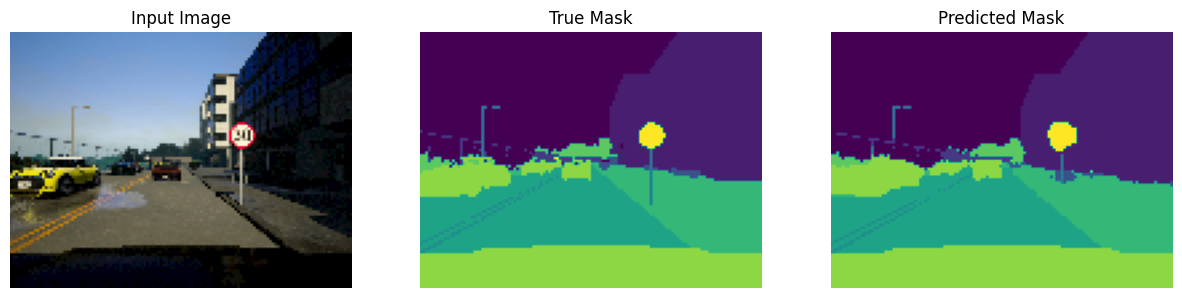

1/1 [==============================] - 1s 875ms/step


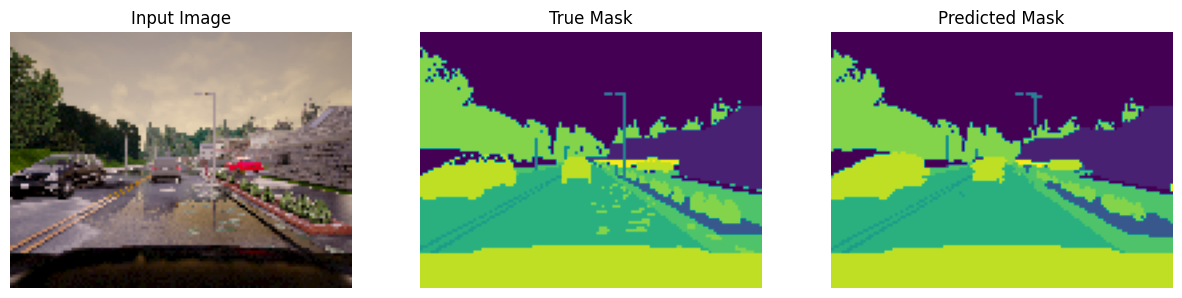

1/1 [==============================] - 1s 904ms/step


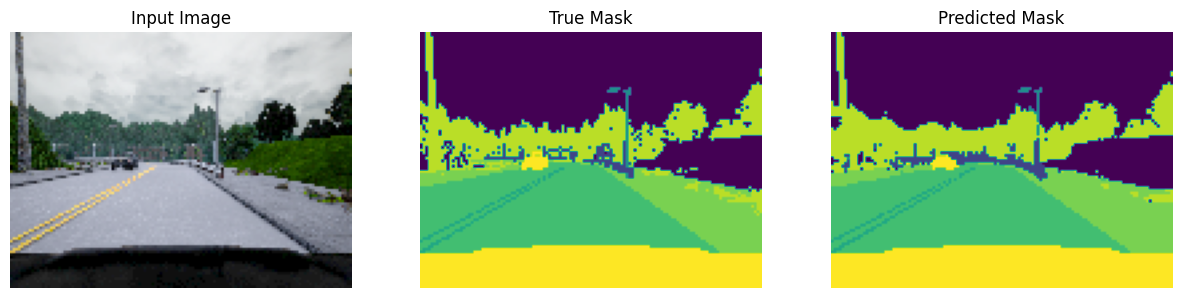

In [21]:
# check predicted masks against the true mask and the original input image
show_predictions(train_dataset, 6)